# Packages

In [1]:
pwd

'/home/luismaecker/team-extra/imke&luis&moritz'

In [2]:
import xcube
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import regionmask
import seaborn as sns
from scalecast.Forecaster import Forecaster
from scalecast.SeriesTransformer import SeriesTransformer
from sklearn.preprocessing import MinMaxScaler

from xcube.core.store import new_data_store

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

/home/luismaecker/.conda/envs/sif_env/lib/python3.11/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 13.0.0. Please consider upgrading.
  warnings.warn(
2024-06-14 21:15:10.862967: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-14 21:15:13.646912: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Functions

In [3]:

# Function to convert a time series dataset into a format suitable for LSTM
def convert2matrix(data_arr, look_back):
    X, Y = [], []
    for i in range(len(data_arr) - look_back):
        d = i + look_back  
        X.append(data_arr[i:d, :-1])  # Features: data points from i to d (exclusive)
        Y.append(data_arr[d, -1])  # Target: the value at the d-th position (assumes target is the last column)
    return np.array(X), np.array(Y)

In [4]:
# Added y asynchron with t-1 at Xt to X
def convert2matrix(data_arr, look_back):
    X, Y = [], []
    for i in range(1, len(data_arr) - look_back):
        d = i + look_back  
        # Append the feature columns and also include the target column shifted by one.
        # It creates a new array from the feature columns and the lagged target column.
        x_seq = np.array(data_arr[i:d, :-1])
        print(x_seq.shape)

        y_shifted =np.array(data_arr[(i-1):(d-1), -1]).reshape((-1,1))
        print(y_shifted.shape)

        assert x_seq.shape[0] == y_shifted.shape[0]

        x_sequence = np.hstack([x_seq, y_shifted])
        
        X.append(x_sequence)
        # Target: the value at the d-th position (assumes target is the last column)
        Y.append(data_arr[d-1, -1])
    return np.array(X), np.array(Y)


In [5]:

# Evaluation function for model performance
def evaluate_model(true_values, predicted_values, data_type='Train'):
    """
    Evaluates the model performance by calculating RMSE and MAE.

    Parameters:
    true_values (np.array): Array of true values.
    predicted_values (np.array): Array of predicted values.
    data_type (str): Type of data being evaluated (Train/Test). Default is 'Train'.

    Returns:
    None
    """
    rmse = np.sqrt(mean_squared_error(true_values, predicted_values))
    mae = mean_absolute_error(true_values, predicted_values)
    print(f'{data_type} Root Mean Squared Error (RMSE): {rmse:.2f}')
    print(f'{data_type} Mean Absolute Error (MAE): {mae:.2f}')


# Data Setup

### Load and subset cube

In [6]:
store = new_data_store("s3", root="deep-esdl-public", storage_options=dict(anon=True))
store.list_data_ids()


cube = store.open_data( 'esdc-8d-0.25deg-256x128x128-3.0.1.zarr')

cube = cube.sel(time=slice('2002-01-01','2021-12-31'))

lon_min, lon_max = 5.866, 15.042
lat_min, lat_max = 47.270, 55.058

cube_ger = cube.sel(lon=slice(lon_min, lon_max), lat=slice(lat_min, lat_max))

# LSTM one time series 

## Subset Data

In [7]:
variables = ["evaporation_era5",
            "precipitation_era5", 
            "radiation_era5", 
            "air_temperature_2m", 
            "max_air_temperature_2m", 
            "min_air_temperature_2m",
            "sif_gosif"]

ts_two = cube_ger[variables].isel(lat=4, lon=12).to_dataframe()


## train and test split

In [8]:
data = ts_two

In [9]:
# Load your data into a pandas DataFrame (assuming 'data' is already available)
# Select relevant features including the target variable
features = variables
data = data[features]

# Convert the data to float32 type for compatibility with Keras
data = data.astype('float32')

# Normalize the data to the range [0, 1] for better LSTM performance
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

# Split the data into training and testing sets based on the year
train_data = data[data.index.year < 2017]
test_data = data[(data.index.year >= 2017)]

train_size = len(train_data)
test_size = len(test_data)

train, test = data_scaled[:train_size, :], data_scaled[train_size:train_size + test_size, :]


In [10]:
# Set look_back period, which is the number of previous time steps to use as input features
look_back = 40

# Convert the training and testing data to the required format for LSTM
trainX, trainY = convert2matrix(train, look_back)
testX, testY = convert2matrix(test, look_back)

# Reshape input to be [samples, time steps, features]
# For LSTM, input shape should be (number of samples, look_back, number of features)
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], trainX.shape[2]))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], testX.shape[2]))


(40, 6)
(40, 1)
(40, 6)
(40, 1)
(40, 6)
(40, 1)
(40, 6)
(40, 1)
(40, 6)
(40, 1)
(40, 6)
(40, 1)
(40, 6)
(40, 1)
(40, 6)
(40, 1)
(40, 6)
(40, 1)
(40, 6)
(40, 1)
(40, 6)
(40, 1)
(40, 6)
(40, 1)
(40, 6)
(40, 1)
(40, 6)
(40, 1)
(40, 6)
(40, 1)
(40, 6)
(40, 1)
(40, 6)
(40, 1)
(40, 6)
(40, 1)
(40, 6)
(40, 1)
(40, 6)
(40, 1)
(40, 6)
(40, 1)
(40, 6)
(40, 1)
(40, 6)
(40, 1)
(40, 6)
(40, 1)
(40, 6)
(40, 1)
(40, 6)
(40, 1)
(40, 6)
(40, 1)
(40, 6)
(40, 1)
(40, 6)
(40, 1)
(40, 6)
(40, 1)
(40, 6)
(40, 1)
(40, 6)
(40, 1)
(40, 6)
(40, 1)
(40, 6)
(40, 1)
(40, 6)
(40, 1)
(40, 6)
(40, 1)
(40, 6)
(40, 1)
(40, 6)
(40, 1)
(40, 6)
(40, 1)
(40, 6)
(40, 1)
(40, 6)
(40, 1)
(40, 6)
(40, 1)
(40, 6)
(40, 1)
(40, 6)
(40, 1)
(40, 6)
(40, 1)
(40, 6)
(40, 1)
(40, 6)
(40, 1)
(40, 6)
(40, 1)
(40, 6)
(40, 1)
(40, 6)
(40, 1)
(40, 6)
(40, 1)
(40, 6)
(40, 1)
(40, 6)
(40, 1)
(40, 6)
(40, 1)
(40, 6)
(40, 1)
(40, 6)
(40, 1)
(40, 6)
(40, 1)
(40, 6)
(40, 1)
(40, 6)
(40, 1)
(40, 6)
(40, 1)
(40, 6)
(40, 1)
(40, 6)
(40, 1)
(40, 6)


In [11]:
trainX.shape

(649, 40, 7)

In [12]:
# trainX[694,39,-1] == trainY[693]

In [13]:
# trainX[694,39,-1] == trainY[692]

## Model and predict

In [14]:

# Define the LSTM model
def model_lstm(look_back, features):
    model = Sequential()
    # LSTM layer with 100 units, input_shape specifies the time steps and features
    model.add(LSTM(128, input_shape=(look_back, features), activation='relu'))
    # Dense layer with 1 unit for the output (predicting one value)
    model.add(Dense(64))
    model.add(Dense(1))

    # Compile the model with mean squared error loss and Adam optimizer
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse', 'mae'])
    return model

# Number of features (excluding the target variable for reshaping purposes)
num_features = trainX.shape[2]

# Build the LSTM model
model = model_lstm(look_back, num_features)

# Train the model
history = model.fit(trainX, trainY, epochs=100, batch_size=25, 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)


Epoch 1/100


/home/luismaecker/.conda/envs/sif_env/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0470 - mae: 0.1614 - mse: 0.0470
Epoch 2/100
13/26 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0137 - mae: 0.0870 - mse: 0.0137

/home/luismaecker/.conda/envs/sif_env/lib/python3.11/site-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae,mse
  current = self.get_monitor_value(logs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0118 - mae: 0.0799 - mse: 0.0118
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0073 - mae: 0.0651 - mse: 0.0073
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0051 - mae: 0.0533 - mse: 0.0051
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0041 - mae: 0.0476 - mse: 0.0041
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0034 - mae: 0.0431 - mse: 0.0034
Epoch 7/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0028 - mae: 0.0393 - mse: 0.0028
Epoch 8/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0026 - mae: 0.0373 - mse: 0.0026
Epoch 9/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0023 - mae: 0.0349 - mse: 0.0023
Epoch 10/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0022 - mae: 0.0337 - mse: 0.0022
Epoch 11/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0021 - mae: 0.0326 - mse: 0.0021
Epoch 12/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss:

# Predict 

In [15]:
testX.shape

(189, 40, 7)

In [16]:
len(testX)

189

In [17]:
i =1 
testX[i].shape

(40, 7)

In [18]:

# Predict SIF values for the test data
test_predict = model.predict(testX)
X_test = testX
forecasts = []
# Iterative prediction and substitution
for i in range(len(X_test)):
    print(i)
    forecast = model.predict(X_test[i].reshape(1, look_back, -1))
    forecasts.append(forecast)  # Ensure forecasts are appended to the list correctly

     # Update the next sample if it's not the last one in the dataset
    if i < len(X_test) - 1:

       # Move all previous values one position to the left and place the new forecast at the end
        X_test[i+1, :-1, -1] = X_test[i+1, 1:, -1]  # Shift all but the last element to the left
        X_test[i+1, -1, -1] = forecast[0][0]  # Insert the latest forecast at the end
    
                
#test_predict_replace = model.predict(testX)

#train_predict = model.predict(trainX)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
9
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
11
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
12
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
13
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
14
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
16
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
17
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
18
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
19
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
21
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
22
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
23
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

In [19]:
len(forecasts)

189

In [20]:
forecasts_array = np.array([forecast[0][0] for forecast in forecasts])
forecasts_array.shape

(189,)

In [21]:
len(test_data.index)-(look_back+1)

189

## Plot

In [22]:
testY.shape

(189,)

In [23]:
test_data.index[look_back+1:].shape

(189,)

In [24]:
testY.shape

(189,)

In [25]:
forecasts_array.shape

(189,)

In [26]:
forecasts_array

array([0.0757245 , 0.05256408, 0.04509644, 0.0419055 , 0.04122131,
       0.04320289, 0.05193669, 0.05428265, 0.0393335 , 0.05393915,
       0.05911535, 0.0460567 , 0.04458693, 0.04144833, 0.0599222 ,
       0.07387611, 0.09860085, 0.17511514, 0.26333794, 0.3812576 ,
       0.48892573, 0.60805786, 0.61689174, 0.7447175 , 0.82664293,
       0.8047648 , 0.75772846, 0.7245925 , 0.66987574, 0.5802629 ,
       0.5275909 , 0.46000302, 0.42969942, 0.3958491 , 0.3576676 ,
       0.31904057, 0.28517544, 0.3152555 , 0.3013246 , 0.28425157,
       0.2408316 , 0.21562853, 0.17905766, 0.10259134, 0.08970203,
       0.07653653, 0.06574333, 0.04648814, 0.04815332, 0.04934656,
       0.0538888 , 0.0528862 , 0.04386761, 0.03867198, 0.04534789,
       0.04876953, 0.05283481, 0.06144562, 0.07193906, 0.09187549,
       0.11186489, 0.11839496, 0.20057017, 0.24355246, 0.23029776,
       0.41211832, 0.47536772, 0.52723765, 0.63636667, 0.6220236 ,
       0.71042126, 0.775218  , 0.71438557, 0.75040823, 0.73403

In [27]:
testY.shape

(189,)

In [28]:
forecasts_array.shape

(189,)

In [30]:
test_data.index[look_back+1:]

DatetimeIndex(['2017-11-29', '2017-12-07', '2017-12-15', '2017-12-23',
               '2017-12-31', '2018-01-05', '2018-01-13', '2018-01-21',
               '2018-01-29', '2018-02-06',
               ...
               '2021-10-20', '2021-10-28', '2021-11-05', '2021-11-13',
               '2021-11-21', '2021-11-29', '2021-12-07', '2021-12-15',
               '2021-12-23', '2021-12-31'],
              dtype='datetime64[ns]', name='time', length=189, freq=None)

Test Root Mean Squared Error (RMSE): 0.03
Test Mean Absolute Error (MAE): 0.02
Test Root Mean Squared Error (RMSE): 0.04
Test Mean Absolute Error (MAE): 0.03


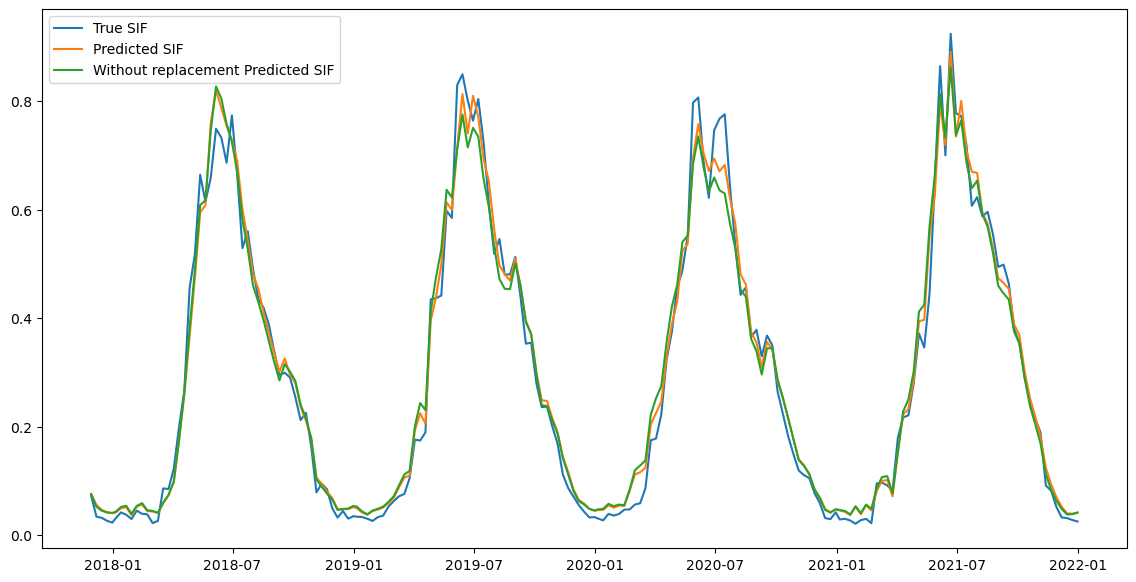

In [29]:
#evaluate_model(trainY, train_predict[:, 0], 'Train')
evaluate_model(testY, test_predict[:,0], 'Test')

evaluate_model(testY, forecasts_array[:], 'Test')

# Plot the true vs predicted SIF values for the test data
plt.figure(figsize=(14, 7))
plt.plot(test_data.index[look_back+1:], testY, label='True SIF')
plt.plot(test_data.index[look_back+1:], test_predict, label='Predicted SIF')
plt.plot(test_data.index[look_back+1:], forecasts_array, label='Without replacement Predicted SIF')
plt.legend()
plt.show()


# Model multiple timeseries

## Subset Data

In [219]:
#TODO: Select only 5 samples - run model once with unified model, once with local

# Initialize an empty list to hold all time series data
all_data_list = []

# Iterate over a selection of lat and lon points within the bounds
for lat in range(0, cube_ger.lat.size, 5):  # adjust step as necessary
    for lon in range(0, cube_ger.lon.size, 5):  # adjust step as necessary
        ts = cube_ger[variables].isel(lat=lat, lon=lon).to_dataframe()
        all_data_list.append(ts)

# Concatenate all the dataframes in the list into a single DataFrame
#all_data = pd.concat(all_data_list)

In [234]:
all_data = pd.concat(all_data_list)

In [235]:
all_data

,evaporation_era5,precipitation_era5,radiation_era5,air_temperature_2m,max_air_temperature_2m,min_air_temperature_2m,sif_gosif,lat,lon
time,,,,,,,,,
2002-01-05,-0.215821,0.000101,196375.687500,-2.776677,3.358864,-7.831108,0.017064,47.375,5.875
2002-01-13,-0.126590,1.147614,161047.609375,-0.503873,5.353485,-6.044052,0.016712,47.375,5.875
2002-01-21,-0.637267,1.484864,109435.742188,5.069724,11.242508,-0.589264,0.013476,47.375,5.875
2002-01-29,-0.967101,2.884482,145259.031250,9.287580,14.749878,3.558693,0.023784,47.375,5.875
2002-02-06,-1.058855,3.308030,176199.468750,9.024652,17.665855,2.887489,0.029932,47.375,5.875
...,...,...,...,...,...,...,...,...,...
2021-11-29,-3.198771,6.249145,63037.753906,4.945324,8.169601,1.897850,NaN,54.875,14.625
2021-12-07,-3.412302,3.876697,44503.558594,2.774391,6.389397,0.146942,NaN,54.875,14.625
2021-12-15,-0.658709,1.237149,52757.410156,5.876523,7.874962,3.235611,NaN,54.875,14.625


In [236]:
len(all_data_list)

56

In [237]:
all_data_list[1]

,evaporation_era5,precipitation_era5,radiation_era5,air_temperature_2m,max_air_temperature_2m,min_air_temperature_2m,sif_gosif,lat,lon
time,,,,,,,,,
2002-01-05,-0.147093,0.001266,197724.187500,-4.467978,1.087906,-9.126526,0.010116,47.375,7.125
2002-01-13,-0.108149,0.296999,188523.359375,-2.374971,4.434921,-8.078964,0.013240,47.375,7.125
2002-01-21,-0.358346,1.606141,133996.687500,3.022328,10.540459,-2.852501,0.015684,47.375,7.125
2002-01-29,-0.798115,2.188191,178672.843750,7.634531,14.031967,2.000351,0.023580,47.375,7.125
2002-02-06,-0.754830,3.302425,192166.312500,6.780427,15.504234,0.954773,0.026272,47.375,7.125
...,...,...,...,...,...,...,...,...,...
2021-11-29,-0.529116,3.563609,116562.828125,1.241272,6.944641,-1.738037,0.016076,47.375,7.125
2021-12-07,-0.460392,8.397724,103399.859375,1.486604,6.979446,-3.612053,0.016956,47.375,7.125
2021-12-15,-0.106292,0.709651,132841.593750,0.045930,2.988693,-2.804153,0.017676,47.375,7.125


In [246]:
# Reset index to have a single time index
all_data.reset_index(inplace=True)

# Filter the data for the years of interest and sort by time
# all_data = all_data[all_data['time'].dt.year <= 2019]
#all_data.sort_values('time', inplace=True)

# remove nan 
all_data = all_data.replace([np.inf, -np.inf], np.nan).dropna()

# Convert the numerical columns to float32 type for compatibility with Keras
all_data[variables] = all_data[variables].astype('float32')

In [247]:
all_data.shape

(46920, 10)

In [248]:
all_data.lat.unique()

array([47.375, 48.625, 49.875, 51.125, 52.375, 53.625, 54.875])

In [249]:
all_data.lon.unique()

array([ 5.875,  7.125,  8.375,  9.625, 10.875, 12.125, 13.375, 14.625])

In [251]:
all_data.columns

Index(['time', 'evaporation_era5', 'precipitation_era5', 'radiation_era5',
       'air_temperature_2m', 'max_air_temperature_2m',
       'min_air_temperature_2m', 'sif_gosif', 'lat', 'lon'],
      dtype='object')

## train and test split

In [252]:


# Normalize the data using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
all_data_scaled = scaler.fit_transform(all_data[variables])

# Convert the scaled data back to a DataFrame for easier manipulation
all_data_scaled = pd.DataFrame(all_data_scaled, columns=variables)
all_data_scaled['time'] = all_data['time'].values  # Preserve the time column

# Split the data into training, validation, and testing sets based on the year
train_data = all_data_scaled[all_data_scaled['time'].dt.year <= 2016]
val_data = all_data_scaled[all_data_scaled['time'].dt.year == 2017]
test_data = all_data_scaled[all_data_scaled['time'].dt.year >= 2018]

# Drop the 'time' column for training, validation, and testing
train = train_data.drop(columns=['time']).values
val = val_data.drop(columns=['time']).values
test = test_data.drop(columns=['time']).values


print(f'Train shape: {train.shape}')
print(f'Validation shape: {val.shape}')
print(f'Test shape: {test.shape}')

# Set look_back period
look_back = 30

# Convert the training, validation, and testing data to the required format for LSTM
trainX, trainY = convert2matrix(train, look_back)
valX, valY = convert2matrix(val, look_back)
testX, testY = convert2matrix(test, look_back)

print(f'TrainX shape: {trainX.shape}, TrainY shape: {trainY.shape}')
print(f'ValX shape: {valX.shape}, ValY shape: {valY.shape}')
print(f'TestX shape: {testX.shape}, TestY shape: {testY.shape}')

# Reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], trainX.shape[2]))
valX = np.reshape(valX, (valX.shape[0], valX.shape[1], valX.shape[2]))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], testX.shape[2]))

print(f'Reshaped TrainX shape: {trainX.shape}')
print(f'Reshaped ValX shape: {valX.shape}')
print(f'Reshaped TestX shape: {testX.shape}')

Train shape: (35190, 7)
Validation shape: (2346, 7)
Test shape: (9384, 7)
(30, 6)
(30, 1)
(30, 6)
(30, 1)
(30, 6)
(30, 1)
(30, 6)
(30, 1)
(30, 6)
(30, 1)
(30, 6)
(30, 1)
(30, 6)
(30, 1)
(30, 6)
(30, 1)
(30, 6)
(30, 1)
(30, 6)
(30, 1)
(30, 6)
(30, 1)
(30, 6)
(30, 1)
(30, 6)
(30, 1)
(30, 6)
(30, 1)
(30, 6)
(30, 1)
(30, 6)
(30, 1)
(30, 6)
(30, 1)
(30, 6)
(30, 1)
(30, 6)
(30, 1)
(30, 6)
(30, 1)
(30, 6)
(30, 1)
(30, 6)
(30, 1)
(30, 6)
(30, 1)
(30, 6)
(30, 1)
(30, 6)
(30, 1)
(30, 6)
(30, 1)
(30, 6)
(30, 1)
(30, 6)
(30, 1)
(30, 6)
(30, 1)
(30, 6)
(30, 1)
(30, 6)
(30, 1)
(30, 6)
(30, 1)
(30, 6)
(30, 1)
(30, 6)
(30, 1)
(30, 6)
(30, 1)
(30, 6)
(30, 1)
(30, 6)
(30, 1)
(30, 6)
(30, 1)
(30, 6)
(30, 1)
(30, 6)
(30, 1)
(30, 6)
(30, 1)
(30, 6)
(30, 1)
(30, 6)
(30, 1)
(30, 6)
(30, 1)
(30, 6)
(30, 1)
(30, 6)
(30, 1)
(30, 6)
(30, 1)
(30, 6)
(30, 1)
(30, 6)
(30, 1)
(30, 6)
(30, 1)
(30, 6)
(30, 1)
(30, 6)
(30, 1)
(30, 6)
(30, 1)
(30, 6)
(30, 1)
(30, 6)
(30, 1)
(30, 6)
(30, 1)
(30, 6)
(30, 1)
(30, 6)
(30, 1

In [253]:
# Assuming train, test, val, and all_data are already defined
total_rows = train.shape[0] + test.shape[0] + val.shape[0]
assert total_rows == all_data.shape[0], f"The shapes do not match. Sum of train, test, and val rows: {total_rows}, all_data rows: {all_data.shape[0]}"


## Model and predict

In [255]:
epochs = 3

In [98]:
# Define an improved LSTM model
def improved_model_lstm(look_back, features):
    model = Sequential()
    model.add(LSTM(100, return_sequences=True, input_shape=(look_back, features), activation='relu'))
    model.add(Dropout(0.2))
    #model.add(LSTM(50, return_sequences=True, activation='relu'))
    #model.add(Dropout(0.2))
   # model.add(LSTM(50, activation='relu'))
    #model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse', 'mae'])
    return model

# Number of features
num_features = trainX.shape[2]

# Build the improved LSTM model
model = improved_model_lstm(look_back, num_features)

# Train the model
history = model.fit(trainX, trainY, epochs=epochs, batch_size=32, validation_data=(valX, valY), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)




Epoch 1/3


/home/luismaecker/.conda/envs/sif_env/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1099/1099 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.0279 - mae: 0.1191 - mse: 0.0279 - val_loss: 0.0114 - val_mae: 0.0709 - val_mse: 0.0114
Epoch 2/3
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 0.0125 - mae: 0.0753 - mse: 0.0125 - val_loss: 0.0097 - val_mae: 0.0654 - val_mse: 0.0097
Epoch 3/3
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 0.0108 - mae: 0.0699 - mse: 0.0108 - val_loss: 0.0093 - val_mae: 0.0637 - val_mse: 0.0093


## Plot Training progress

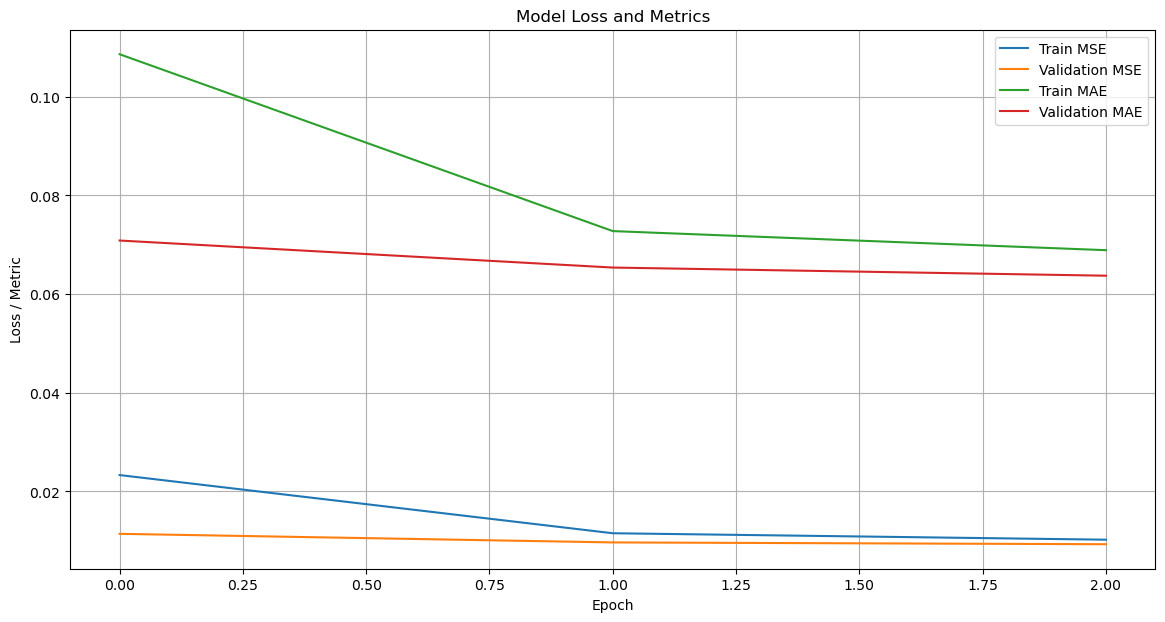

In [103]:

# Plot training & validation loss values
plt.figure(figsize=(14, 7))

plt.plot(history.history['mse'], label='Train MSE')
plt.plot(history.history['val_mse'], label='Validation MSE')
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model Loss and Metrics')
plt.xlabel('Epoch')
plt.ylabel('Loss / Metric')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()


## Predict

In [104]:
valX.shape

(2316, 30, 7)

In [106]:
#TODO: appky recusive changing to use predictions not true y

# Predict SIF values for the validation and test data
val_predict = model.predict(valX)
test_predict = model.predict(testX)

print(f'ValY shape: {valY.shape}, Val_predict shape: {val_predict.shape}')
print(f'TestY shape: {testY.shape}, Test_predict shape: {test_predict.shape}')

# Flatten the predictions to match the shape of valY and testY
val_predict = val_predict[:, -1, 0]
test_predict = test_predict[:, -1, 0]

print(f'ValY shape: {valY.shape}, Val_predict shape: {val_predict.shape}')
print(f'TestY shape: {testY.shape}, Test_predict shape: {test_predict.shape}')

73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
ValY shape: (2316,), Val_predict shape: (2316, 30, 1)
TestY shape: (4662,), Test_predict shape: (4662, 30, 1)
ValY shape: (2316,), Val_predict shape: (2316,)
TestY shape: (4662,), Test_predict shape: (4662,)


## Plot val and test results

In [ ]:
print(valY.shape)
print(val_predict.shape)

print(testY.shape)
print(test_predict.shape)

In [ ]:
# Evaluation function for model performance
def evaluate_model(true_values, predicted_values, data_type='Validation'):
    # Remove NaN values
    mask = ~np.isnan(predicted_values)
    print(mask.shape)
    print(true_values.shape)
    
    true_values = true_values[mask]
    predicted_values = predicted_values[mask]
    
    if len(true_values) > 0 and len(predicted_values) > 0:
        rmse = np.sqrt(mean_squared_error(true_values, predicted_values))
        mae = mean_absolute_error(true_values, predicted_values)
        print(f'{data_type} Root Mean Squared Error (RMSE): {rmse:.2f}')
        print(f'{data_type} Mean Absolute Error (MAE): {mae:.2f}')
    else:
        print(f'{data_type} evaluation skipped due to insufficient data.')

In [ ]:
testY.shape

In [ ]:
# Evaluate the model on the validation and test data
# evaluate_model(valY, val_predict, 'Validation')
evaluate_model(testY, test_predict, 'Test')

plt.figure(figsize=(14, 7))
plt.plot(test_data.index[30:], testY, label='True SIF')
plt.plot(test_data.index[30:], test_predict, label='Predicted SIF')
plt.legend()
plt.show()